In [9]:
library(datateachr)
library(cowplot)
library(infer)
library(knitr)
library(tidyverse)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



pop_mean,single_sample_mean,sampling_mean
<dbl>,<dbl>,<dbl>
0.2694092,0.2393569,0.2693335


Warning message:
“Removed 43 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


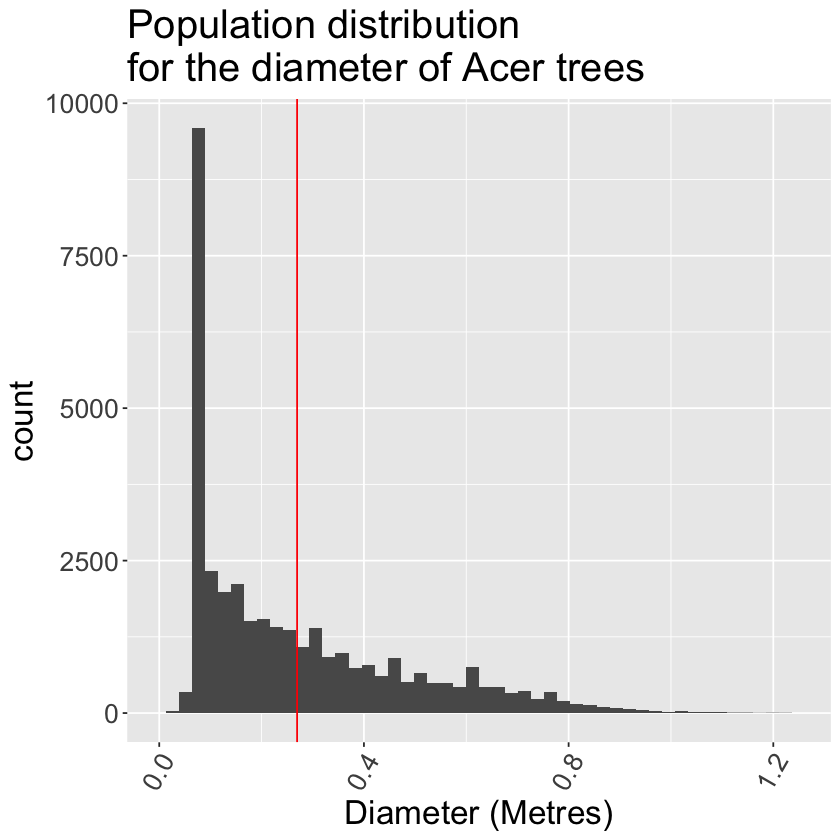

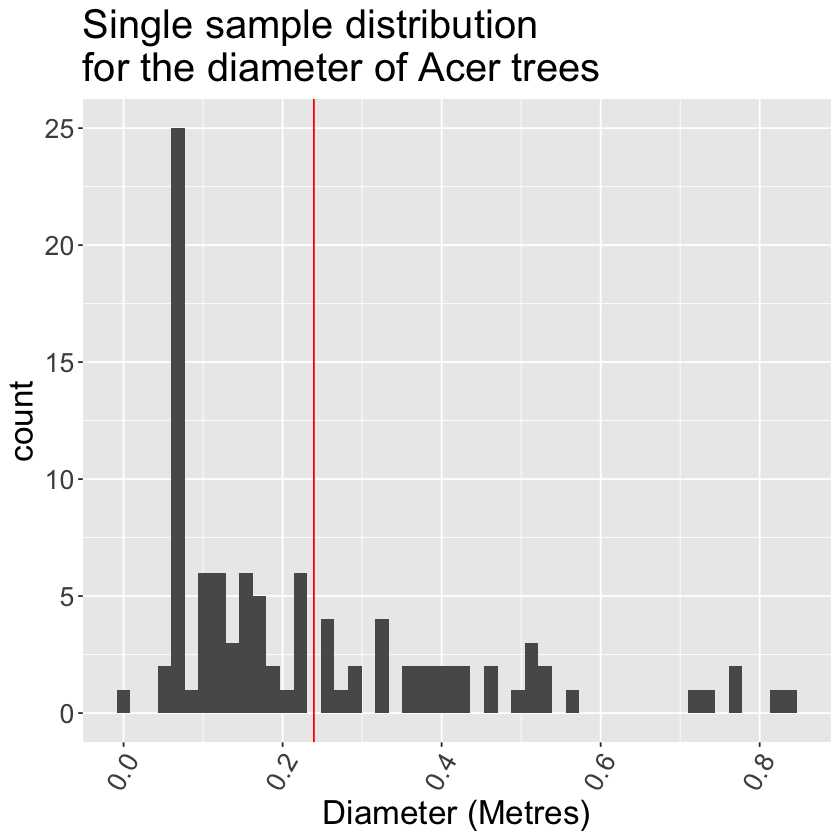

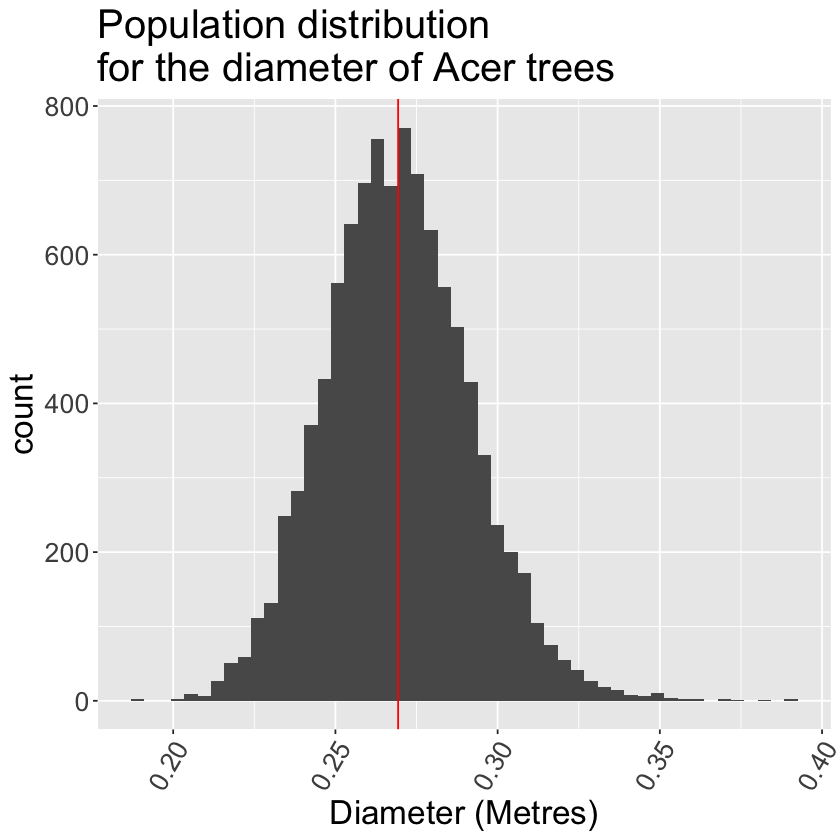

In [10]:
set.seed(2020)

# data and mean
# ---------------------------------------------------------------------------

# ------------------------------
# population and population_mean
# ------------------------------
acer_pop <- vancouver_trees %>%
    filter(genus_name == "ACER") %>%
    mutate(diameter = diameter * 0.0254) %>% 
    select(diameter)

pop_mean <- acer_pop %>%
  summarize(pop_mean = mean(diameter)) %>%
  pull(pop_mean)


# ------------------------------
# single sample and its mean
# ------------------------------
single_sample <- acer_pop %>% 
    rep_sample_n(size = 100)

single_sample_mean <- single_sample %>% 
    summarise(single_sample_mean = mean(diameter)) %>% 
    select(-replicate) %>% 
    pull(single_sample_mean)


# ------------------------------
# 10000 samples and its mean
# ------------------------------
acer_samples <- acer_pop %>%
    rep_sample_n(size = 100, reps = 10000)

samples_estimates <- acer_samples %>%
    group_by(replicate) %>%
    summarise(samples_mean = mean(diameter))

sampling_mean <- samples_estimates %>% 
    pull(samples_mean) %>%
    mean()


three_means <- tibble(pop_mean = pop_mean,
       single_sample_mean = single_sample_mean,
       sampling_mean = sampling_mean)




# visualization
# ---------------------------------------------------------------------------
# helper function to reduce duplication
dist_plot_helper <- function(data, col, sample_mean, title, nbins = 50) {
    data %>% 
    ggplot(aes(x = {{col}})) +
        geom_histogram(bins = nbins) +
        xlab("Diameter (Metres)") +
        geom_vline(xintercept = sample_mean, colour = "red") + 
        ggtitle(paste(title, "\nfor the diameter of Acer trees")) +
        theme(text = element_text(size = 20),
             axis.text.x = element_text(angle = 60, hjust = 1))
}

# ------------------------------
# sampling distribution
# ------------------------------
sampling_dist <- dist_plot_helper(samples_estimates,
                                           samples_mean,
                                           sampling_mean, 
                                           "Population distribution")

# ------------------------------
# population distribution
# ------------------------------
population_dist <- dist_plot_helper(acer_pop, 
                                           diameter,
                                           pop_mean, 
                                           "Population distribution")

# ------------------------------
# Single sample distribution
# ------------------------------
single_sample_dist <- dist_plot_helper(single_sample, 
                                           diameter,
                                           single_sample_mean, 
                                           "Single sample distribution")


# the means of three distribution
three_means


# the distribution plot
population_dist + xlim(c(0, 1.25))
single_sample_dist
sampling_dist

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“Removed 9 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”




Table: The sample size, mean, and standard error of each sampling distribution

|sample_size |   mean    | standard_error |
|:-----------|:---------:|:--------------:|
|10          | 0.2687819 |   0.0695927    |
|30          | 0.2695513 |   0.0404440    |
|100         | 0.2694577 |   0.0220961    |

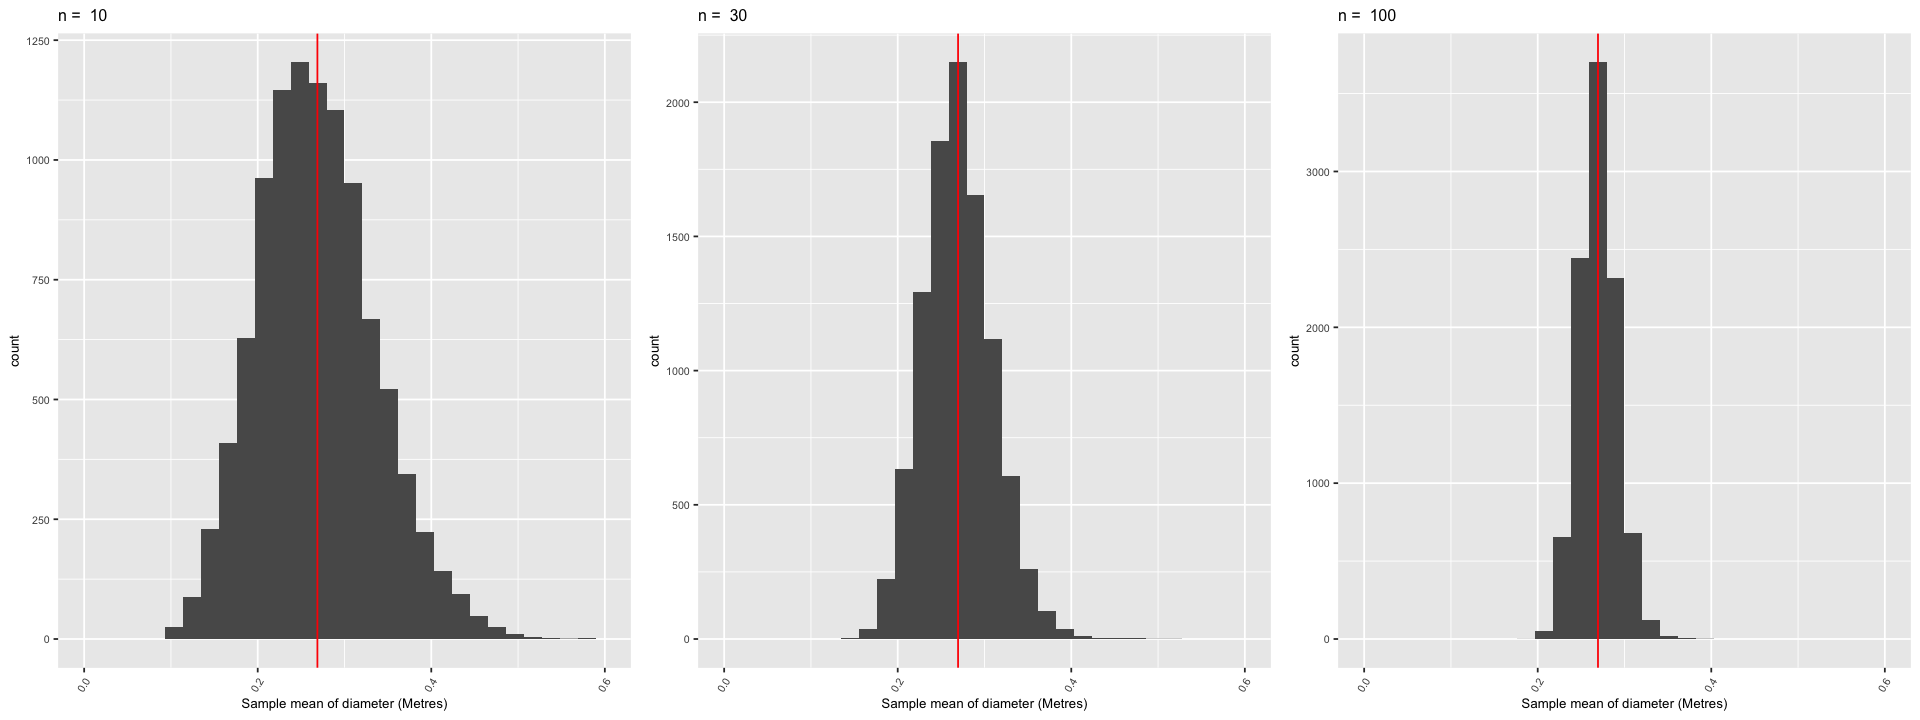

In [34]:
# sampling helper function that returns the plot and stat data
# ------------------------------------------------------------
sampling_helper <- function(data, col, fun, sample_size, nbins = 30) {
    # sample estimates
    sample_estimates <- data %>% 
        rep_sample_n(size = sample_size, reps = 10000) %>% 
        group_by(replicate) %>% 
        summarise(sample_estimate = fun({{ col }}))
    
     # stat - mean
    sampling_mean <- sample_estimates %>% 
        pull(sample_estimate) %>% 
        mean()
    
    # stat - standard error
    std_error <- sample_estimates %>% 
        pull(sample_estimate) %>% 
        sd()   
    
    # distribution plot
    plot <- sample_estimates %>% ggplot(aes(x = sample_estimate)) +
        geom_histogram(bins = nbins) +
        xlim(c(0, 0.6)) +
        xlab("Sample mean of diameter (Metres)") +
        geom_vline(xintercept = sampling_mean, colour = "red") + 
        ggtitle(paste("n = ", sample_size)) +
        theme(text = element_text(size = 8),
             axis.text.x = element_text(angle = 60, hjust = 1))
    
    # put all stat in a tibble
    stat <- tibble(sample_size = sample_size, 
                  mean = sampling_mean,
                  standard_error = std_error)
    
    # return both plot and stat tibble
    return (list(plot, stat))
    
}



# three sampling distributions of different sample size
# ------------------------------------------------------------
sampling_dist_10 <- acer_pop %>%
    sampling_helper(diameter,
             mean,
             10)


sampling_dist_30 <- acer_pop %>%
    sampling_helper(diameter,
             mean,
             30)

sampling_dist_100 <- acer_pop %>%
    sampling_helper(diameter,
             mean,
             100)



# plots for three distributions
# ------------------------------------------------------------
options(repr.plot.width = 16, repr.plot.height = 6)
plot_grid(sampling_dist_10[[1]],
          sampling_dist_30[[1]],
          sampling_dist_100[[1]],
          ncol = 3)



# the table showing the sample size, mean, standard error for three sampling distributions
# --------------------------------------------------------------------------------------------
all_stat <- rbind(sampling_dist_10[[2]], 
                  sampling_dist_30[[2]], 
                  sampling_dist_100[[2]])

knitr::kable(all_stat, 
             align = "lccrr", 
             caption = "The sample size, mean, and standard error of each sampling distribution")

Setting `type = "bootstrap"` in `generate()`.



bootstrap_sample_size,num_samples,mean,standard_error
<dbl>,<dbl>,<dbl>,<dbl>
100,10000,0.2393905,0.01935013


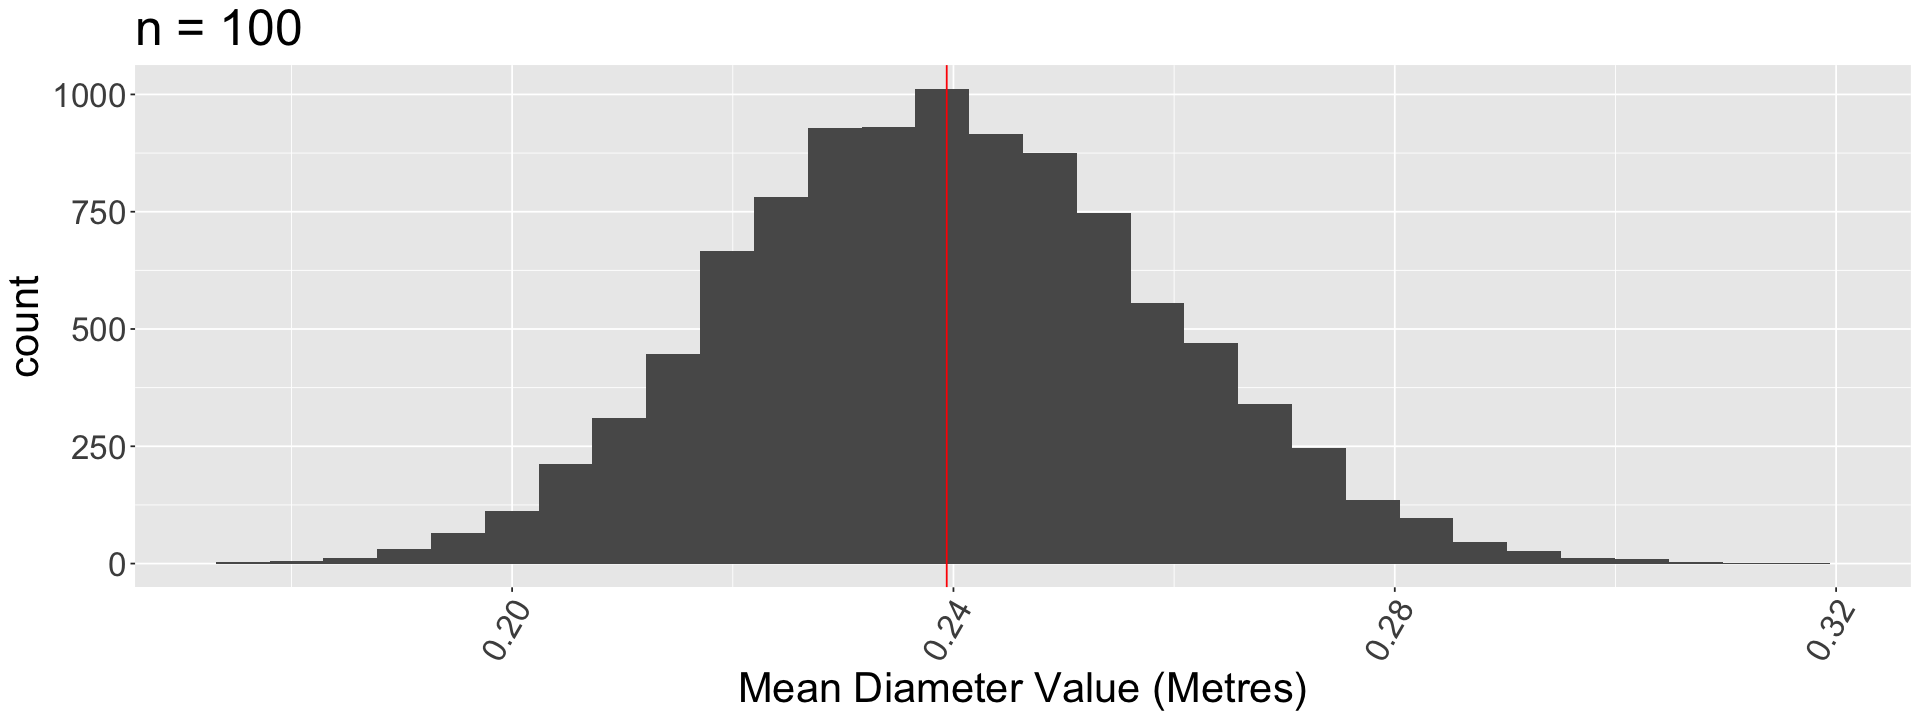

In [44]:
# create bootstrap sampling data
bootstrap_means_10 <- single_sample %>% 
    ungroup() %>% # CAUTION
    specify(response = diameter) %>% 
    generate(reps = 10000) %>% 
    calculate(stat = "mean")


# calculate the mean of bootstrap distribution
bootstrap_dist_mean <- bootstrap_means_10 %>% 
    pull(stat) %>% 
    mean()

# calculate the standard error of bootstrap distribution
bootstrap_dist_sd <- bootstrap_means_10 %>% 
    pull(stat) %>% 
    sd()

# plot bootstrap distribution
bootstrap_dist_10 <- bootstrap_means_10 %>% 
    ggplot(aes(x = stat)) +
    geom_histogram(bins = 30) +
    xlab("Mean Diameter Value (Metres)") +
    geom_vline(xintercept = bootstrap_dist_mean, colour = "red") + 
    ggtitle("n = 100") +
    theme(text = element_text(size = 25),
          axis.text.x = element_text(angle = 60, hjust = 1))


# the table that contains the mean and standard error of bootstrap distribution
bootstrap_stat_param <- tibble(bootstrap_sample_size = 100,
                               num_samples = 10000,
                               mean = bootstrap_dist_mean,
                               standard_error = bootstrap_dist_sd)

bootstrap_dist_10
bootstrap_stat_param

In [92]:
library(testthat)

# create a sampling distribution
sampling_dist_30 <- acer_pop %>%
    sampling_helper(diameter,
             mean,
             30)



# test plot
test_plot <- function(){
    
  dist <- sampling_dist_30[[1]]
  properties <- c(dist$layers[[1]]$mapping, dist$mapping)
  
  test_that("Plot should have diameter on the x-axis", {
    expect_true("sample_estimate" == rlang::get_expr(properties$x))
  })
  
  test_that("Plot should be a histogram", {
    expect_true("GeomBar" %in% class(dist$layers[[1]]$geom))
  })
  
  test_that("Plot should use 30 bins", {
    expect_equal(mget("stat_params", dist$layers[[1]])[["stat_params"]][["bins"]], 30)
  })
  
  test_that("Plot does not use the correct data", {
    expect_equal(nrow(dist$data), 10000)
    expect_true("sample_estimate" %in% colnames(dist$data))
  })
  
  test_that("x-axis label should be descriptive and human readable", {
    expect_false((dist$labels$x) == "sample_estimate")
  })
  print("success!")
}


# test stat table: mean, standard error
test_stat_table <- function(){
    stat <- sampling_dist_30[[2]]
    
    test_that("answer should be a data frame", {
        expect_true(is.data.frame(stat))
    })
    test_that('answer should have 1 rows', {
        expect_equal(nrow(stat), 1)
    })
    test_that('answer should have 3 columns', {
        expect_equal(ncol(stat), 3)
    })
    test_that('answer should have column names sample_size, mean, and standard_error', {
        expect_equal(paste(tolower(sort(colnames(stat))), collapse = ""), 'meansample_sizestandard_error')
    })
    test_that("answer has is incorrect values", {
        expect_equal(paste(stat$sample_size, collapse = ""), '30')
    })
    print("success!")
}

test_plot()
test_stat_table()

`summarise()` ungrouping output (override with `.groups` argument)



[1] "success!"
[1] "success!"
